
Reference:
- https://fasttext.cc/docs/en/unsupervised-tutorial.html
- https://blog.csdn.net/feilong_csdn/article/details/88655927

Deep average network


Unlabeled dataset:
   -  upsample by few shot learning (upsample)
   -  A Siamese neural network upsample
   

Mainly based on Hw3

In [4]:
import pandas as pd
import numpy as np
import torch
import random

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    USE_CUDA=True

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    USE_CUDA=False

No GPU available, using the CPU instead.


In [5]:
SEED = 30255 # Specify a seed for reproducability

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
train_df = pd.read_csv('data/Twitter/hate_twitter/hate_train.csv')
val_df = pd.read_csv('data/Twitter/hate_twitter/hate_val.csv')
test_df = pd.read_csv('data/Twitter/hate_twitter/hate_test.csv')


# Check and drop na values in clean_tweet column
train_df[train_df['clean_tweet'].isnull()]

train_df = train_df[train_df['clean_tweet'].notna()]
val_df = val_df[val_df['clean_tweet'].notna()]
test_df = test_df[test_df['clean_tweet'].notna()]


x_train = train_df['clean_tweet']
y_train = train_df['label']

x_test = test_df['clean_tweet']
y_test = test_df['label']

x_val = val_df['clean_tweet']
y_val = val_df['label']




In [7]:
train_df.groupby('label').size()

label
0    20776
1     1574
dtype: int64

## Convert to Pytorch Data Objects


In [8]:
'''
dataclassCNN.py
File to create a Custom Data Class and Collate Function for PyTorch.
This file is for the CNN model.
'''
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer


class ProjectDataset(Dataset):

    def __init__(self, data, target_col=None, text_col=None):

        # Target first, then Inputs.
        self.samples = []
        tokenizer = get_tokenizer('basic_english')

        if not target_col and not text_col:
            targets = list(data[0])
            inputs = list(data[1])
            for idx in range(len(targets)):
                text = tokenizer(inputs[idx])
                self.samples.append([targets[idx], text])
        else:
            for _, row in data.iterrows():
                text = row[text_col]
                text = tokenizer(text)
                target = row[target_col]
                self.samples.append([target, text])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [9]:
data_obj = ProjectDataset(train_df, 'label', 'clean_tweet')

## Load Pre-trained vectors GloVe 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
from torchtext import datasets

from collections import Counter
from torchtext.vocab import vocab

import numpy as np
import random

In [11]:
from collections import Counter
from torchtext.vocab import vocab


counter_words = Counter()
for (label, text) in data_obj:
    counter_words.update(text)
    
vocab_words = vocab(counter_words)
vocab_words.set_default_index(0)


print('The vocabulary length is {} words'.format(len(vocab_words)))


VECTORS_CACHE_DIR = './.vector_cache'


from torchtext import vocab

pretrained_emb = vocab.GloVe(name='6B',cache=VECTORS_CACHE_DIR)

print('Max number of words for a given tweet in the Dataset:')
max_len = train_df["clean_tweet"].apply(lambda x: len(x.split())).max()
print(max_len)

pre_trained_vectors = pretrained_emb.get_vecs_by_tokens(vocab_words.get_itos(),
                                                       lower_case_backup=True)

The vocabulary length is 32820 words


./.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:42<00:00, 9423.59it/s]


Max number of words for a given tweet in the Dataset:
21


In [12]:
def collate_for_cnn(batch, max_len=max_len):
    '''
    For each batch, develop the appropiate inputs from the models (i.e. embeddings)
    '''
    input_vector = []
    labels = []
    for i, (label, tokenized_sent) in enumerate(batch):
        
        #Append labels 
        labels.append(label)
        
        #Get tokenized sentence
        diff =  (max_len - len(tokenized_sent))
        tokenized_sent += ['<pad>'] * diff
        
        assert(len(tokenized_sent) == max_len), tokenized_sent
        
        wordstoidx = [vocab_words[w] for w in tokenized_sent]
        input_vector.append(wordstoidx)
    
    return torch.tensor(labels).to(device), torch.tensor(input_vector).to(device)


In [13]:
# from torch.utils.data import DataLoader

# W = 1
# WINDOW_SIZE = (2 * W + 1)

# TAG = 'ud'

# def collate_for_cnn(batch, w = W, tag = TAG):
    
#     ## WRITE YOUR CODE BELOW
#     labels = []
#     word_idxs = []

#     for idx in range(len(batch)):
#         one_word_idx = []
#         word_lst = batch[idx][0]

#         # index of the tag for the center word
#         center = w
#         center_word_tag = batch[idx][1][center]
#         tag_idx = vocab_words[center_word_tag]
#         labels.append(tag_idx)

#         #  index of each of the words in the example
#         for word in word_lst:
#             one_word_idx.append(vocab_words[word])
        
#         word_idxs.append(one_word_idx)

#     word_idxs = torch.LongTensor(word_idxs)
#     labels = torch.LongTensor(labels)
#     # print(word_idxs)
#     # print(labels)

#     ## WRITE YOUR CODE ABOVE
#     # The tensors you return should be placed in the correct device
#     # as shown below.
#     return labels.to(device), word_idxs.to(device)


## Setting up DataLoader Class

In [14]:
from torch.utils.data import DataLoader

def data_loader(train_tuple, val_tuple, test_tuple,
                batch_size=30):
    """Convert train, validation and test sets into Dataloaders
    """

    # Create DataLoader for training data
    train_data = ProjectDataset(train_tuple)
    train_dataloader = DataLoader(train_data, shuffle=True,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)
    
    # Create DataLoader for validation data
    valid_data = ProjectDataset(val_tuple)
    val_dataloader = DataLoader(valid_data, shuffle=False,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)

    # Create DataLoader for test data
    test_data = ProjectDataset(test_tuple)
    test_dataloader = DataLoader(test_data, shuffle=False,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)

    return train_dataloader, val_dataloader, test_dataloader

In [15]:
train_dataloader, val_dataloader, test_dataloader = data_loader([y_train, x_train],
                                                               [y_val, x_val],
                                                               [y_test, x_test])

In [16]:
for i in train_dataloader:
    labels, inputs = i[0], i[1]
    print(inputs.shape)
    break

torch.Size([30, 21])


## CNN Model

In [17]:
FILTER_SIZES = [3,4,5]
N_FILTERS = [100, 100,100]
DROPOUT = 0.5
PAD_IDX = vocab_words['<pad>']
num_classes = 2 #0, 1

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_classification(nn.Module):
    ''' An 1D Convulational Neural Network for Sentence Classification'''
    
    def __init__(self, pretrained_embedding=None, freeze_embedding=False,
                 vocab_size=None, embed_dim=None,
                 filter_sizes=FILTER_SIZES, num_filters=N_FILTERS,
                 num_classes=num_classes,pad_id=PAD_IDX,
                 dropout=DROPOUT):
        """
        pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (int): Number of filters. Default: 100
            n_classes (int): Number of classes. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_classification, self).__init__()
        
        # 1. Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx= pad_id,
                                          )
        
        # 2. Convolutional Layers (for each filter size --> n-gram)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.embed_dim,
                                              out_channels = num_filters[i], 
                                              kernel_size = fs)
                                    for i, fs in enumerate(filter_sizes)
                                    ])
        
    
        # 3. Fully-connected layer
        self.linear = nn.Linear(in_features = np.sum(num_filters), 
                                out_features = num_classes
                               )
        
        
        # Additional Feature
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, inputs):

        x_embedded = self.embedding(inputs)
        
        x_embedded = x_embedded.permute(0, 2, 1)
        
        # Apply CNN and ReLU
        convs_list = [F.relu(conv(x_embedded)) for conv in self.convs]

        # Max pooling.
        pooled = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]).squeeze(2)
                  for x_conv in convs_list]
        
        # Concatenate Pool list to feed the fully connected layer
        input_fc = self.dropout(torch.cat(pooled, dim = 1))
        
        # Compute probabilities
        predictions_classes = self.linear(input_fc)
        
        return predictions_classes

In [19]:
def train_an_epoch(model, dataloader, loss_function, optimizer):
    
    model.train() # Sets the module in training mode.
    total_loss = 0
    
    for idx, batch in enumerate(dataloader):
        
        # Load batch to GPU
        labels, inputs = tuple(t.to(device) for t in batch)
        
        # Zero out any previously calculated gradients
        model.zero_grad()
        
        #Perform a forward pass.
        log_probs = model(inputs)
        
        # Compute loss and accumulate the loss values
        loss = loss_function(log_probs, labels.long())
        total_loss += loss.item()
        
        # Perform a backward pass to calculate gradients
        loss.backward()
        optimizer.step()
    
    return total_loss/len(dataloader)

In [66]:
# !pip3 install torchmetrics

     |████████████████████████████████| 409 kB 7.4 MB/s 


In [74]:
from torchmetrics import F1Score, Accuracy, Recall, Precision

def evaluate(model, dataloader, loss_fn):
    '''
    Evaluate the model on the given data (e.g. validation data or test data).
    '''

    #As we are now using dropout, we must remember to use model.eval() 
    #to ensure the dropout is "turned off" while evaluating.
    model.eval()
    
    total_accuracy = []
    total_loss = []
    total_recall = []
    total_precision = []
    total_f1_score = []
    
    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        for i, batch in enumerate(dataloader):
            
            # Load batch to Device
            labels, inputs = batch[0], batch[1]
            if USE_CUDA:
                labels, inputs = labels.cuda(), inputs.cuda()
                
            # Obtain probabilities of each class per sentence
            output = model(inputs)
            
            # Compute loss
            loss = loss_fn(output, labels.long())
            total_loss.append(loss.item())

            # Get the predictions
            preds = torch.argmax(output, dim=1).flatten()
            
            # Calculate the accuracy rate
            accuracy = (preds == labels).sum()/len(preds)
            total_accuracy.append(accuracy)

            # Calculate the recall score
            # print(((preds == labels) & (labels == 1)).sum())
            # print((labels == 1).sum())
            # print(torch.sum(labels == 1))
            # print(torch.sum((preds == labels) & (labels == 1)))
            recall = Recall()
            recall_score = recall(preds, labels).item()
            total_recall.append(recall_score)
            # recall = torch.sum((preds == labels) & (labels == 1)) / torch.sum(labels == 1)
            # recall = len(((preds == labels) & (labels == 1)).sum()) / len((labels == 1).sum())
            total_recall.append(recall_score)

            # Calculate the precision score
            # precision = torch.sum((preds == labels) & (labels == 1)) / torch.sum(preds == 1)
            # precision = len(((preds == labels) & (labels == 1)).sum()) / len((preds == 1).sum())
            precision = Precision()
            precision_score = precision(preds, labels).item()
            total_precision.append(precision_score)

            # Calculate the f1 score
            # f1_score = (2 * recall * precision) / (recall + precision)
            f1 = F1Score(num_classes=2)
            f1_score = f1(preds, labels).item()
            total_f1_score.append(f1_score)

    return np.mean(total_loss), np.mean(total_accuracy), np.mean(total_recall), np.mean(total_precision), np.mean(total_f1_score)

In [75]:
import datetime

def train_validate(model, optimizer, train_dataloader, val_dataloader, pretrained_embedding, epochs=20):
    
    """Train the CNN model."""
    
    #Loss function
    loss_function = nn.CrossEntropyLoss()
    
    # Tracking best model
    val_losses = []
    val_accuracies = []
    val_recalls = []
    val_precisions = []
    val_f1_scores = []
    best_model = None
    
    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Time(secs)':^8} | {'Train Loss':^9}| {'Val Loss':^10}| {'Val Acc':^11} | {'Val Recall':^12}  | {'Val Precision':^13}  | {'Val F1':^14}")
    print("-"*120)

    for epoch_i in range(epochs):
        start_time = datetime.datetime.now()
        # =======================================
        #               Training
        # =======================================
        
        avg_loss_train = train_an_epoch(model, train_dataloader, loss_function, optimizer)
        
        # =======================================
        #               Evaluation
        # =======================================
        
        val_loss, val_accuracy, val_recall, val_precision, val_f1 = evaluate(model, val_dataloader, loss_function)

        # Track the best model
        if len(val_losses) == 0 or val_loss < min(val_losses):
            best_model = type(model)(pretrained_embedding=pretrained_embedding,
                                     vocab_size=len(vocab_words), 
                                     embed_dim=model.embed_dim,
                                     filter_sizes=FILTER_SIZES,
                                     num_filters=N_FILTERS, num_classes=num_classes)
            best_model.load_state_dict(model.state_dict())
            if USE_CUDA:
                best_model = best_model.cuda()
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_recalls.append(val_recall)
        val_precisions.append(val_precision)
        val_f1_scores.append(val_f1)
        
        time_diff = (datetime.datetime.now() - start_time).seconds
        
        print(f"{epoch_i + 1:^7} |  {time_diff:^8}  | {avg_loss_train:^9.2f} | {val_loss:^10.2f}| {val_accuracy:^11.2f}| {val_recall:^12.2f}| {val_precision:^13.2f} | {val_f1:^14.2f}")
        print('')
        
    return best_model, val_accuracies, val_recalls, val_precisions, val_f1_scores

## Train the model

In [76]:
cnn_model = CNN_classification(pretrained_embedding=None,
                 vocab_size=len(vocab_words), embed_dim=400,
                        freeze_embedding=False,
                        filter_sizes=FILTER_SIZES,
                        num_filters=N_FILTERS,
                        num_classes=num_classes,
                        dropout=0.5).to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(cnn_model.parameters(), 
                                 lr=learning_rate)



In [77]:
best_model, val_accuracies, val_recalls, val_precisions, val_f1_scores = train_validate(cnn_model, optimizer, 
                                            train_dataloader, val_dataloader, 
                                            pretrained_embedding=None,
                                            epochs=5)

Start training...

 Epoch  | Time(secs) | Train Loss|  Val Loss |   Val Acc   |  Val Recall   | Val Precision  |     Val F1    
------------------------------------------------------------------------------------------------------------------------
   1    |    135     |   0.20    |    0.15   |    0.96    |     0.96    |     0.96      |      0.96     

   2    |    144     |   0.09    |    0.16   |    0.96    |     0.96    |     0.96      |      0.96     

   3    |    145     |   0.04    |    0.23   |    0.96    |     0.96    |     0.96      |      0.96     

   4    |    149     |   0.04    |    0.27   |    0.96    |     0.95    |     0.95      |      0.95     

   5    |    153     |   0.03    |    0.32   |    0.95    |     0.95    |     0.95      |      0.95     



## Test the best model

In [78]:
#Loss function
loss_function = nn.CrossEntropyLoss()
test_loss, test_accuracy, test_recall, test_precision, test_f1_score = evaluate(best_model, test_dataloader, loss_function)

In [79]:
print(f"{test_loss:^10.2f}| {test_accuracy:^11.2f}| {test_recall:^12.2f}| {test_precision:^13.2f} | {test_f1_score:^14.2f}")


   0.13   |    0.96    |     0.96    |     0.96      |      0.96     


In [80]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(model, test_loader, device='cpu'):
    print('Evaluate')
    y_pred = []
    y_true = []

    total_accuracy = []

    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        for i, batch in enumerate(test_loader):
            # Load batch to Device
            labels, inputs = batch[0], batch[1]
            labels, inputs = labels.to(device), inputs.to(device)
            # Obtain probabilities of each class per sentence
            output = model(inputs)
            # Get the predictions
            preds = torch.argmax(output, dim=1).flatten()
            # Calculate the accuracy rate
            accuracy = (preds == labels).sum()/len(preds)
            total_accuracy.append(accuracy)
            y_pred.extend(list(preds))
            y_true.extend(list(labels))

    acc = 0.0
    for i, y in enumerate(y_pred):
        if y == y_true[i]:
            acc += 1.0

    acc = acc / len(y_pred)

    print('Test Accuracy: ', acc)

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1, 0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])

    return None

Evaluate
Test Accuracy:  0.9586811352253757
Classification Report:
              precision    recall  f1-score   support

           1     0.8596    0.4579    0.5976       321
           0     0.9623    0.9946    0.9782      4471

    accuracy                         0.9587      4792
   macro avg     0.9110    0.7263    0.7879      4792
weighted avg     0.9555    0.9587    0.9527      4792



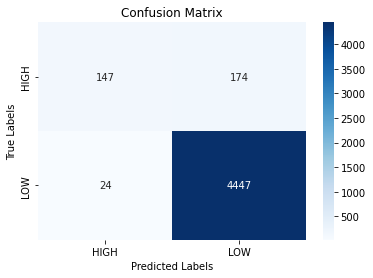

In [81]:
plot_metrics(best_model, test_dataloader)
